# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [77]:

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0


from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split

# Importing from tensorflow.keras instead of keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [78]:
# Load your data into a pandas dataframe here
df = pd.read_csv('household_power_consumption_cleaned.csv')
df.columns

C:\Users\tehwh\AppData\Local\Temp\ipykernel_9932\4100361903.py:2: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('household_power_consumption_cleaned.csv')


Index(['datetime', 'Date', 'Time', 'Global_active_power',
       'Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'],
      dtype='object')

In [79]:
# getting the data types of the columns
df.dtypes

datetime                  object
Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [80]:
# Assign size for data subset (1% of the total data)
subset_size = int(len(df) * 0.01)

# Take random data subset
data_subset = df.sample(n=subset_size)

# Split data subset 80/20 for train/validation
train_df, val_df = train_test_split(data_subset, test_size=0.2)

In [81]:
# reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

val_df['Global_active_power'] = pd.to_numeric(val_df['Global_active_power'], errors='coerce')
val_df['Global_active_power'].fillna(val_df['Global_active_power'].mean(), inplace=True)

In [82]:
train_df['Global_active_power'] = pd.to_numeric(train_df['Global_active_power'], errors='coerce')

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [83]:
seq_arrays = []
seq_labs = []

In [84]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

for i in range(len(train_df) - seq_length - ph):
    seq_arrays.append(train_df[feat_cols].iloc[i:i+seq_length].values)
    # Append a single value, ensure it's not an array
    seq_labs.append(train_df[feat_cols].iloc[i+seq_length+ph-1].values[0])

# Convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)

print("seq_arrays shape:", seq_arrays.shape)
print("seq_labs shape:", seq_labs.shape)

seq_arrays shape: (16566, 30, 1)
seq_labs shape: (16566,)


In [85]:
expected_seq_arrays_length = len(train_df)-seq_length-ph
print("Expected seq_arrays length:", expected_seq_arrays_length)
print("Actual seq_arrays length:", seq_arrays.shape[0])

Expected seq_arrays length: 16566
Actual seq_arrays length: 16566


In [86]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph, seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [87]:
seq_arrays.shape

(16566, 30, 1)

In [88]:
# Prepare sequences and labels for the validation set
val_seq_arrays = []
val_seq_labs = []

for i in range(len(val_df) - seq_length - ph):
    val_seq_arrays.append(val_df[feat_cols].iloc[i:i+seq_length].values)
    val_seq_labs.append(val_df[feat_cols].iloc[i+seq_length+ph-1].values[0])

# Convert to numpy arrays and floats to appease keras/tensorflow        
val_seq_arrays = np.array(val_seq_arrays, dtype=object).astype(np.float32)
val_seq_labs = np.array(val_seq_labs, dtype=object).astype(np.float32)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: They are used to validate the Numpy arrays, and it is important because the dimensions of the arrays have to correct for the training process, and if they fail it means we have to fix it. 

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [89]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = len(feat_cols)
nb_out = ph

model = Sequential()

# add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),  # Input shape (sequence length, number of features)
         units=5,  # First LSTM layer with 5 hidden units
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,  # Second LSTM layer with 3 hidden units
          return_sequences=False))
model.add(Dropout(0.2))

# add output layer
model.add(Dense(units=nb_out))  # Output layer with units equal to predictive horizon
model.add(Activation('linear'))  # Linear activation function for regression output

# compile the model
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 5)             140       
                                                                 
 dropout_4 (Dropout)         (None, 30, 5)             0         
                                                                 
 lstm_5 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_5 (Dropout)         (None, 3)                 0         
                                                                 
 dense_2 (Dense)             (None, 5)                 20        
                                                                 
 activation_2 (Activation)   (None, 5)                 0         
                                                                 
Total params: 268 (1.05 KB)
Trainable params: 268 (1.0

In [90]:
history = model.fit(
    seq_arrays, 
    seq_labs,   
    epochs=50,         
    batch_size=64,     
    validation_data=(val_seq_arrays, val_seq_labs),  
    verbose=2          
)

Epoch 1/50
259/259 - 6s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 6s/epoch - 25ms/step
Epoch 2/50
259/259 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 12ms/step
Epoch 3/50
259/259 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 12ms/step
Epoch 4/50
259/259 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 12ms/step
Epoch 5/50
259/259 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 12ms/step
Epoch 6/50
259/259 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 12ms/step
Epoch 7/50
259/259 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 12ms/step
Epoch 8/50
259/259 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 12ms/step
Epoch 9/50
259/259 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch - 12ms/step
Epoch 10/50
259/259 - 3s - loss: nan - mse: nan - val_loss: nan - val_mse: nan - 3s/epoch -

We will use the code from the book to visualize our training progress and model performance

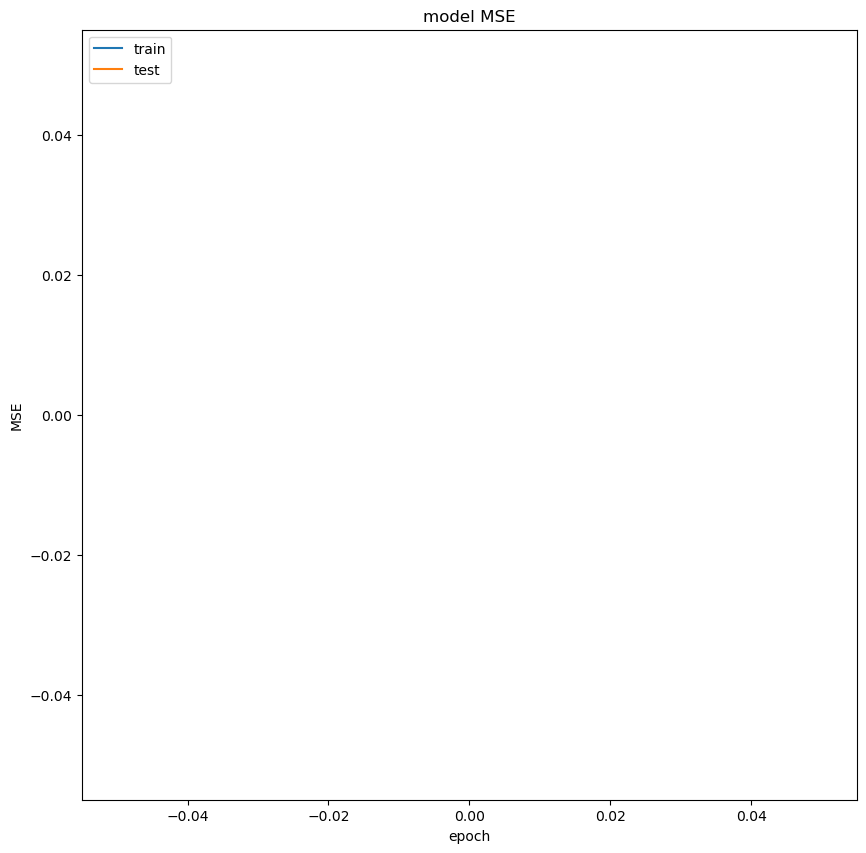

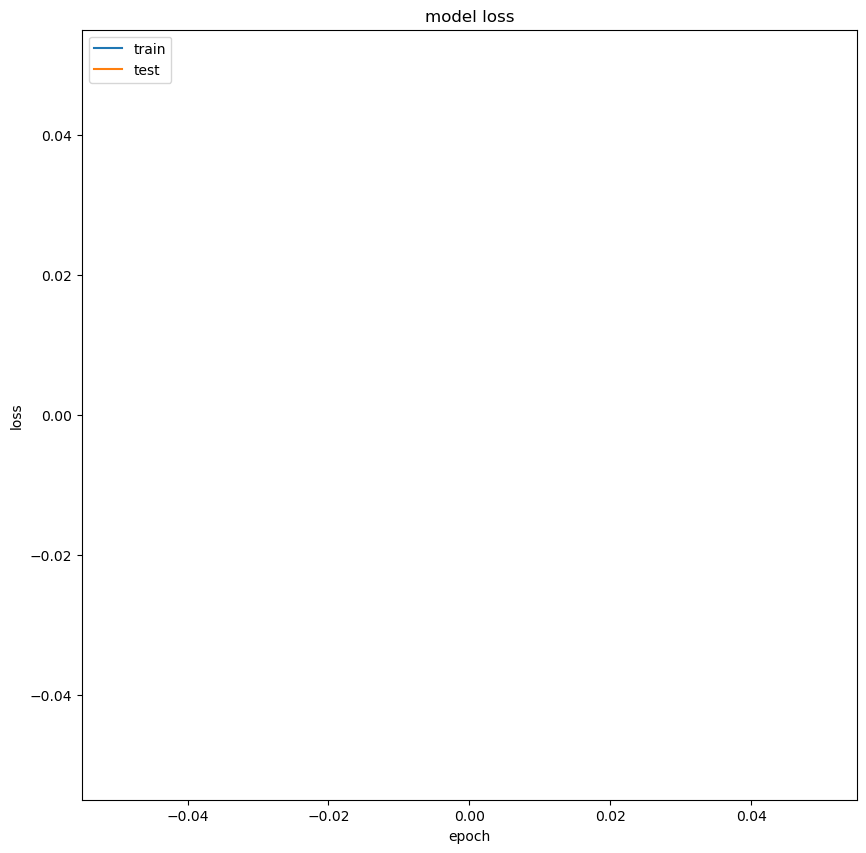

In [91]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The padding sequence helps standardize the data. It is used when dealing with data that has different lengths. 

In [93]:
val_arrays = []
val_labs = []

# create list of GAP readings starting with a minimum of two readings
for i in range(len(val_df) - seq_length - ph):
    val_arrays.append(val_df[feat_cols].iloc[i:i+seq_length].values)
    val_labs.append(val_df[feat_cols].iloc[i+seq_length+ph-1].values[0])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='post', dtype='float32')   
        
# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

129/129 - 0s - loss: nan - mse: nan - 464ms/epoch - 4ms/step

MSE: nan
129/129 [==============================] - 1s 4ms/step


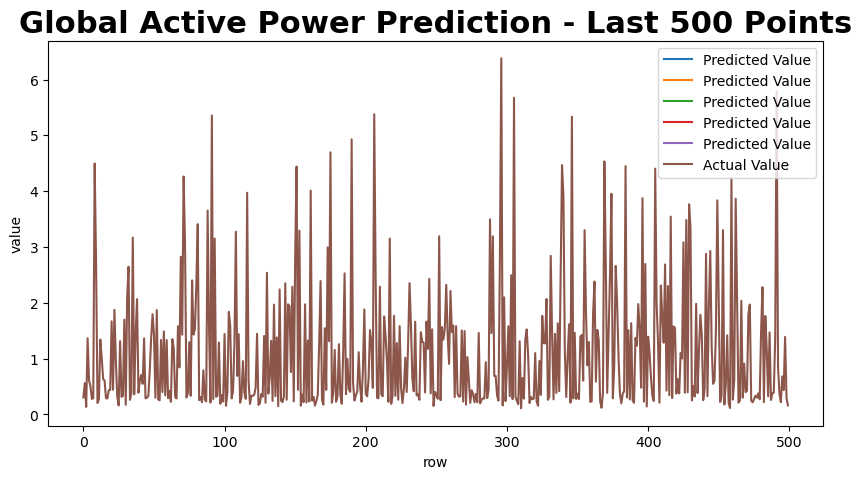

In [94]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: 


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: To keep it simple I am going to change the number of the LTSM units, I will double them to see if they have anymore improved performance.  

In [100]:
# reloading the data
df = pd.read_csv('household_power_consumption_cleaned.csv')
df.columns

C:\Users\tehwh\AppData\Local\Temp\ipykernel_9932\1987531749.py:2: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('household_power_consumption_cleaned.csv')


Index(['datetime', 'Date', 'Time', 'Global_active_power',
       'Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'],
      dtype='object')

In [101]:
# only doing 1 percent of the data again and then re-applying the same data clensing steps 
subset_size = int(len(df) * 0.01)
data_subset = df.sample(n=subset_size)
data_subset = data_subset.reset_index()

data_subset['Global_active_power'] = pd.to_numeric(data_subset['Global_active_power'], errors='coerce')
data_subset['Global_active_power'].fillna(data_subset['Global_active_power'].mean(), inplace=True)

seq_length = 30
ph = 5
feat_cols = ['Global_active_power']

# prepare sequences and labels for the test set
test_seq_arrays = []
test_seq_labs = []

for i in range(len(data_subset) - seq_length - ph + 1):
    test_seq_arrays.append(data_subset[feat_cols].iloc[i:i+seq_length].values)
    test_seq_labs.append(data_subset[feat_cols].iloc[i+seq_length+ph-1].values[0])

# convert to numpy arrays and floats for keras/tensorflow
test_seq_arrays = np.array(test_seq_arrays, dtype=object).astype(np.float32)
test_seq_labs = np.array(test_seq_labs, dtype=object).astype(np.float32)

# use the pad_sequences function on your input sequences
test_seq_arrays = pad_sequences(test_seq_arrays, maxlen=seq_length, padding='post', dtype='float32')
test_seq_labs = np.array(test_seq_labs, dtype='float32')

In [102]:
# splitting 
train_seq_arrays, val_seq_arrays, train_seq_labs, val_seq_labs = train_test_split(
    test_seq_arrays, test_seq_labs, test_size=0.2, random_state=42
)

In [103]:
def create_lstm_model(input_shape, lstm_units, dense_units, dropout_rate, optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units))
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [105]:
number_of_features = 1
input_shape = (seq_length, number_of_features)

In [106]:
# model 1
model_1 = create_lstm_model(input_shape, lstm_units=50, dense_units=1, dropout_rate=0.2)

# training 
history_1 = model_1.fit(
    train_seq_arrays,
    train_seq_labs,
    epochs=50,
    batch_size=64,
    validation_data=(val_seq_arrays, val_seq_labs),
    verbose=2
)


Epoch 1/50
259/259 - 8s - loss: 1.1166 - val_loss: 1.0324 - 8s/epoch - 33ms/step
Epoch 2/50
259/259 - 5s - loss: 1.0951 - val_loss: 1.0380 - 5s/epoch - 19ms/step
Epoch 3/50
259/259 - 5s - loss: 1.0921 - val_loss: 1.0246 - 5s/epoch - 19ms/step
Epoch 4/50
259/259 - 5s - loss: 1.0928 - val_loss: 1.0267 - 5s/epoch - 19ms/step
Epoch 5/50
259/259 - 5s - loss: 1.0903 - val_loss: 1.0254 - 5s/epoch - 19ms/step
Epoch 6/50
259/259 - 5s - loss: 1.0936 - val_loss: 1.0250 - 5s/epoch - 19ms/step
Epoch 7/50
259/259 - 5s - loss: 1.0908 - val_loss: 1.0255 - 5s/epoch - 19ms/step
Epoch 8/50
259/259 - 5s - loss: 1.0913 - val_loss: 1.0247 - 5s/epoch - 18ms/step
Epoch 9/50
259/259 - 5s - loss: 1.0902 - val_loss: 1.0254 - 5s/epoch - 18ms/step
Epoch 10/50
259/259 - 5s - loss: 1.0889 - val_loss: 1.0266 - 5s/epoch - 19ms/step
Epoch 11/50
259/259 - 5s - loss: 1.0901 - val_loss: 1.0244 - 5s/epoch - 18ms/step
Epoch 12/50
259/259 - 5s - loss: 1.0885 - val_loss: 1.0246 - 5s/epoch - 19ms/step
Epoch 13/50
259/259 - 5s

In [107]:
# model 2 
model_2 = create_lstm_model(input_shape, lstm_units=100, dense_units=1, dropout_rate=0.2)

# training
history_2 = model_2.fit(
    train_seq_arrays,
    train_seq_labs,   
    epochs=50,
    batch_size=64,
    validation_data=(val_seq_arrays, val_seq_labs),
    verbose=2
)

Epoch 1/50
259/259 - 11s - loss: 1.1136 - val_loss: 1.0243 - 11s/epoch - 44ms/step
Epoch 2/50
259/259 - 8s - loss: 1.0950 - val_loss: 1.0245 - 8s/epoch - 30ms/step
Epoch 3/50
259/259 - 8s - loss: 1.0934 - val_loss: 1.0246 - 8s/epoch - 30ms/step
Epoch 4/50
259/259 - 8s - loss: 1.0886 - val_loss: 1.0246 - 8s/epoch - 30ms/step
Epoch 5/50
259/259 - 8s - loss: 1.0914 - val_loss: 1.0244 - 8s/epoch - 31ms/step
Epoch 6/50
259/259 - 8s - loss: 1.0931 - val_loss: 1.0252 - 8s/epoch - 31ms/step
Epoch 7/50
259/259 - 8s - loss: 1.0904 - val_loss: 1.0414 - 8s/epoch - 31ms/step
Epoch 8/50
259/259 - 8s - loss: 1.0892 - val_loss: 1.0290 - 8s/epoch - 30ms/step
Epoch 9/50
259/259 - 8s - loss: 1.0861 - val_loss: 1.0259 - 8s/epoch - 30ms/step
Epoch 10/50
259/259 - 8s - loss: 1.0871 - val_loss: 1.0255 - 8s/epoch - 30ms/step
Epoch 11/50
259/259 - 8s - loss: 1.0879 - val_loss: 1.0245 - 8s/epoch - 31ms/step
Epoch 12/50
259/259 - 8s - loss: 1.0874 - val_loss: 1.0254 - 8s/epoch - 32ms/step
Epoch 13/50
259/259 - 8

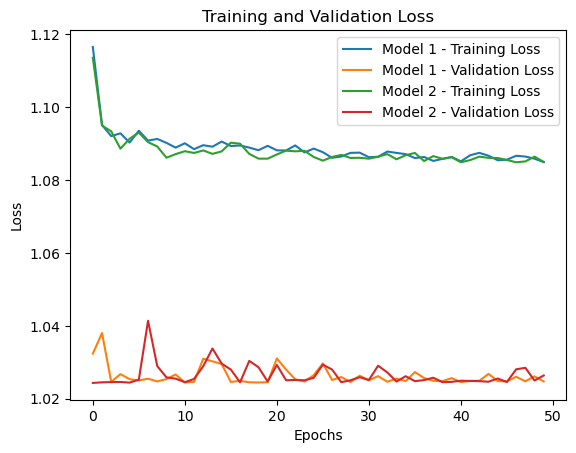

In [108]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above
plt.plot(history_1.history['loss'], label='Model 1 - Training Loss')
plt.plot(history_1.history['val_loss'], label='Model 1 - Validation Loss')
plt.plot(history_2.history['loss'], label='Model 2 - Training Loss')
plt.plot(history_2.history['val_loss'], label='Model 2 - Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: I basically was able to have a better loss and val loss on the second model with 100 neurons vs 50. I think that the model is greatly imporved just by doubling the layers. with that being said, you can always change the optimizers which is what I would do next. 

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Honestly, the guided models are always rough and challanging just due to all of the errors. But With that being said, It think the more complex a model gets sometimes the better. But I think that all models have their own best use case. With that being said, I didn't think that linear regression model is the greatest for the task. 